## Camera Calibration

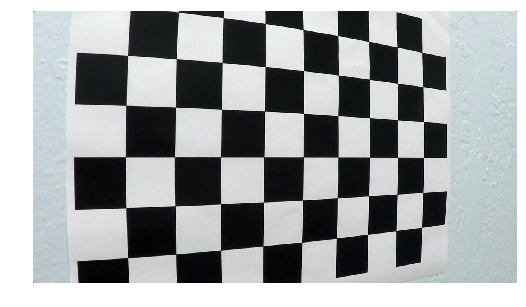

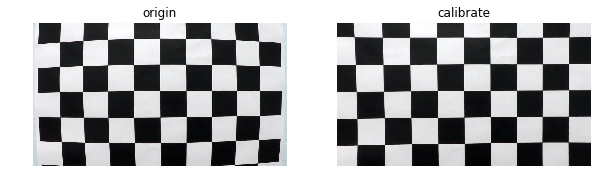

111.19065

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle as pickle


%matplotlib inline


nx=9
ny=6
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
plt.figure(figsize = (10,5))
mtx_all = []
dist_all = []
for i in range(20):
    fname = 'camera_cal/calibration'+ str(i+1) + '.jpg'
    img = cv2.imread(fname)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    #print(str(i+1) + ':' + str(ret))
    #plt.subplot(4,5,i+1)
    if ret == True:
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

        objpoints.append(objp)
        imgpoints.append(corners)
        
        #plt.imshow(img)

    else:
        plt.imshow(img)
    plt.axis('off')
    
fname = 'camera_cal/calibration'+ str(1) + '.jpg'
img = cv2.imread(fname)
img_size = (img.shape[1], img.shape[0])

#plt.imshow(img)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(img)
plt.title('origin')
plt.axis('off')

image_ud = cv2.undistort(img, mtx, dist, None, mtx)

plt.subplot(1,2,2)
plt.imshow(image_ud)
plt.title('calibrate')
plt.axis('off')

plt.show()

data = [mtx,dist]


pickle.dump( data, open( "camera_calibration.pkl", "wb" ) )

corners[1][0][0]

## Test Undistort

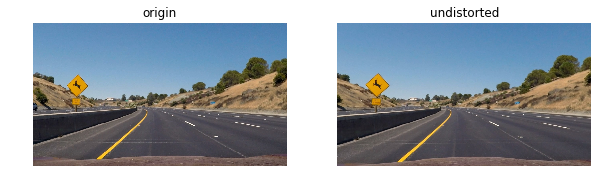

In [2]:
import matplotlib.image as mpimg


fname = 'test_images/test'+ str(2) + '.jpg'
img = mpimg.imread(fname)
img_size = (img.shape[1], img.shape[0])
plt.figure(figsize=(10,4))

undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('origin')

plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(undist)
plt.title('undistorted')


plt.axis('off');
plt.show();




## Helper functions

In [129]:
kernel_size = 5
from scipy.signal import find_peaks_cwt


def get_initial_mask(img,window_size):
    img = gaussian_blur(img,5)
    img_size = np.shape(img)
    mov_filtsize = int(img_size[1]/20.)
    mean_ln = np.mean(img[int(img_size[0]/2):,:],axis=0)
    mean_ln = moving_average(mean_ln,mov_filtsize)
    
    indexes = find_peaks_cwt(mean_lane,[100], max_distances=[800])

    val_ind = np.array([mean_ln[indexes[i]] for i in range(len(indexes)) ])
    ind_sorted = np.argsort(-val_ind)

    ind_peakR = indexes[ind_sorted[0]]
    ind_peakL = indexes[ind_sorted[1]]
    if ind_peakR<ind_peakL:
        ind_temp = ind_peakR
        ind_peakR = ind_peakL
        ind_peakL = ind_temp

    n_vals = 8
    ind_min_L = ind_peakL-window_size
    ind_max_L = ind_peakL+window_size

    ind_min_R = ind_peakR-window_size
    ind_max_R = ind_peakR+window_size

    mask_L_poly = np.zeros_like(img)
    mask_R_poly = np.zeros_like(img)

    ind_peakR_prev = ind_peakR
    ind_peakL_prev = ind_peakL
    
    diff_R = 0
    diff_L = 0
    for i in range(8):
        

        
        img_y1 = int(img_size[0]-img_size[0]*i/8)
        img_y2 = int(img_size[0]-img_size[0]*(i+1)/8)
    
        mean_lane_y = np.mean(img[img_y2:img_y1,:],axis=0)
        mean_lane_y = moving_average(mean_lane_y,mov_filtsize)
        indexes = find_peaks_cwt(mean_lane_y,[100], max_distances=[800])
        
        if len(indexes)>1.5:
            val_ind = np.array([mean_lane[indexes[i]] for i in range(len(indexes)) ])
            ind_sorted = np.argsort(-val_ind)

            ind_peakR = indexes[ind_sorted[0]]
            ind_peakL = indexes[ind_sorted[1]]
            if ind_peakR<ind_peakL:
                ind_temp = ind_peakR
                ind_peakR = ind_peakL
                ind_peakL = ind_temp
            
        else:
            if len(indexes)==1:
                if np.abs(indexes[0]-ind_peakR_prev)<np.abs(indexes[0]-ind_peakL_prev):
                    ind_peakR = indexes[0]
                    ind_peakL = ind_peakL_prev+diff_R
                else:
                    ind_peakL = indexes[0]
                    ind_peakR = ind_peakR_prev+diff_R
            else:
                ind_peakL = ind_peakL_prev+diff_R
                ind_peakR = ind_peakR_prev+diff_R
            
                
        if np.abs(ind_peakL-ind_peakL_prev)>=100:
            ind_peakL = ind_peakL_prev
        if np.abs(ind_peakR-ind_peakR_prev)>=100:
            ind_peakR = ind_peakR_prev
    
            
        mask_L_poly[img_y2:img_y1,int(ind_peakL-window_size):int(ind_peakL+window_size)] = 1.     
        mask_R_poly[img_y2:img_y1,int(ind_peakR-window_size):int(ind_peakR+window_size)] = 1.
        
        if i == 0:
            window_size= window_size/1
   
        if i>0:
            diff_R = ind_peakL-ind_peakL_prev
            diff_L = ind_peakR-ind_peakR_prev

    
        ind_peakL_prev = ind_peakL
        ind_peakR_prev = ind_peakR
        
        
        
    return mask_L_poly,mask_R_poly

def get_mask_poly(img,poly_fit,window_sz):
    
    # This function returns masks for points used in computing polynomial fit. 
    mask_poly = np.zeros_like(img)
    img_size = np.shape(img)

    poly_pts = []
    pt_y_all = []

    for i in range(8):
        img_y1 = img_size[0]-img_size[0]*i/8
        img_y2 = img_size[0]-img_size[0]*(i+1)/8

        pt_y = (img_y1+img_y2)/2
        pt_y_all.append(pt_y)
        poly_pt = np.round(poly_fit[0]*pt_y**2 + poly_fit[1]*pt_y + poly_fit[2])
    
        poly_pts.append(poly_pt)
    
        mask_poly[int(img_y2):int(img_y1),int(poly_pt-window_sz):int(poly_pt+window_sz)] = 1.     

    return mask_poly, np.array(poly_pts),np.array(pt_y_all)
    
def get_val(y,pol_a):
    # Returns value of a quadratic polynomial 
    return pol_a[0]*y**2+pol_a[1]*y+pol_a[2]

def get_curvature(pol_a,y_pt):
    # Returns curvature of a quadratic
    A = pol_a[0]
    B = pol_a[1]
    R_curve = (1+(2*A*y_pt+B)**2)**1.5/np.absolute(2*A)
    return R_curve

def draw_pw_lines(img,pts,color):
    # draw lines
    pts = np.int_(pts)
    for i in range(10):
        x1 = pts[0][i][0]
        y1 = pts[0][i][1]
        x2 = pts[0][i+1][0]
        y2 = pts[0][i+1][1]
        cv2.line(img, (x1, y1), (x2, y2),color,50)
        

def undistort_image(img, mtx, dist):
    # Undistort image
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img
def gaussian_blur(img, kernel=5):
    # Apply Gaussian Blur
    blur = cv2.GaussianBlur(img,(kernel,kernel),0)
    return blur

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    if orient=='x':
        img_s = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    else:
        img_s = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    img_abs = np.absolute(img_s)
    img_sobel = np.uint8(255*img_abs/np.max(img_abs))
    
    binary_output = 0*img_sobel
    binary_output[(img_sobel >= thresh[0]) & (img_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    img_sx = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    img_sy = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    
    img_s = np.sqrt(img_sx**2 + img_sy**2)
    img_s = np.uint8(img_s*255/np.max(img_s))
    binary_output = 0*img_s
    binary_output[(img_s>=thresh[0]) & (img_s<=thresh[1]) ]=1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    img_sx = cv2.Sobel(img,cv2.CV_64F,1,0, ksize=sobel_kernel)
    img_sy = cv2.Sobel(img,cv2.CV_64F,0,1, ksize=sobel_kernel)
    
    grad_s = np.arctan2(np.absolute(img_sy), np.absolute(img_sx))
    
    binary_output = 0*grad_s # Remove this line
    binary_output[(grad_s>=thresh[0]) & (grad_s<=thresh[1])] = 1
    return binary_output
    
def GaussianC_Adaptive_Threshold(img,kernel,cut_val):
    # Apply Gaussian adaptive thresholding
    img_cut = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,kernel,cut_val)
    return img_cut

def warp_image(img,src,dst,img_size):
    # Apply perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return warped,M,Minv

def sobel_combined(image):
    # Apply combined sobel filter
    img_g_mag = mag_thresh(image,3,(20,150))
    img_d_mag = dir_threshold(image,3,(.6,1.1))
    img_abs_x = abs_sobel_thresh(image,'x',5,(50,200))
    img_abs_y = abs_sobel_thresh(image,'y',5,(50,200))
    sobel_combined = np.zeros_like(img_d_mag)
    sobel_combined[((img_abs_x == 1) & (img_abs_y == 1)) | \
               ((img_g_mag == 1) & (img_d_mag == 1))] = 1
    return sobel_combined


def color_mask(hsv,low,high):
    # Return mask from HSV 
    mask = cv2.inRange(hsv, low, high)
    return mask

def apply_color_mask(hsv,img,low,high):
    # Apply color mask to image
    mask = cv2.inRange(hsv, low, high)
    res = cv2.bitwise_and(img,img, mask= mask)
    return res

def moving_average(a, n=3):
    # Moving average
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


## Load Image and undistort


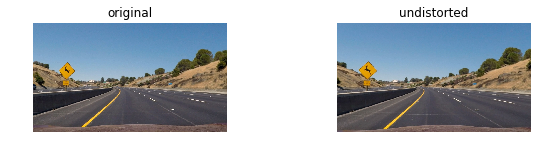

In [4]:
import pickle as pickle

fname = 'test_images/test'+ str(2) + '.jpg'
img = mpimg.imread(fname)
pkl_file = open("camera_calibration.pkl", 'rb')
mtx_camera, dist_camera= pickle.load(pkl_file)
image_ud = undistort_image(img, mtx_camera , dist_camera)


plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('off');
plt.title('original')
plt.subplot(1,2,2)
plt.imshow(image_ud)
plt.title('undistorted')
plt.axis('off');

## Image Transforms(color, gradients)

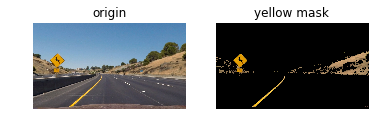

In [5]:

def apply_yellow_mask(image_ud):
    image_HSV = cv2.cvtColor(image_ud,cv2.COLOR_RGB2HSV)
    yellow_hsv_low  = np.array([ 0,  100,  100])
    yellow_hsv_high = np.array([ 80, 255, 255])
    res_mask = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
    image_yellow = apply_color_mask(image_HSV,image_ud,yellow_hsv_low,yellow_hsv_high)
    
    return image_yellow

plt.subplot(1,2,1)
plt.imshow(image_ud)
plt.title('origin')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(apply_yellow_mask(image_ud))
plt.title('yellow mask')
plt.axis('off');





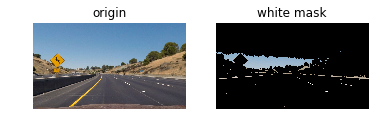

In [6]:
def apply_white_mask(image_ud):
    image_HSV = cv2.cvtColor(image_ud,cv2.COLOR_RGB2HSV)
    white_hsv_low  = np.array([ 0,   0,   160])
    white_hsv_high = np.array([ 255,  80, 255])
    image_white = apply_color_mask(image_HSV,image_ud,white_hsv_low,white_hsv_high)
    return image_white

plt.subplot(1,2,1)
plt.imshow(image_ud)
plt.title('origin')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(apply_white_mask(image_ud))
plt.title('white mask')
plt.axis('off');


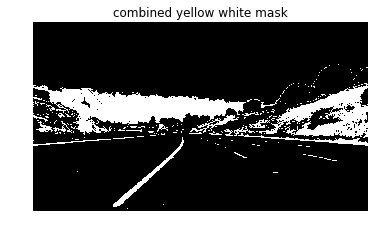

In [7]:
def apply_yellow_white_mask(image_ud):
    image_HSV = cv2.cvtColor(image_ud,cv2.COLOR_RGB2HSV)
    yellow_hsv_low  = np.array([ 0,  100,  100])
    yellow_hsv_high = np.array([ 80, 255, 255])
    white_hsv_low  = np.array([ 0,   0,   160])
    white_hsv_high = np.array([ 255,  80, 255])   
    mask_yellow = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
    mask_white = color_mask(image_HSV,white_hsv_low,white_hsv_high)
    mask_YW_image = cv2.bitwise_or(mask_yellow,mask_white)
    return mask_YW_image


plt.imshow(apply_yellow_white_mask(image_ud),cmap='gray')
plt.title('combined yellow white mask')
plt.axis('off');


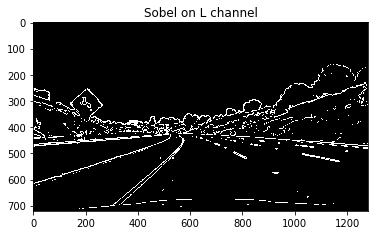

In [8]:

def apply_sobel_L(image_ud):
    image_HLS = cv2.cvtColor(gaussian_blur(image_ud, kernel=5),cv2.COLOR_RGB2HLS)
    img_gs = image_HLS[:,:,1]
    #img_gs = cv2.cvtColor(warped,cv2.COLOR_RGB2GRAY)
    sobel_c = sobel_combined(img_gs)
    #img_d_mag = dir_threshold(img_gs,3,(.6,1.1))
    #img_m_mag = mag_thresh(img_gs,5,(20,265))
    img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,225))
    img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,225))
    sobel_L_image = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    return sobel_L_image


plt.title('Sobel on L channel')
plt.imshow(apply_sobel_L(image_ud),cmap='gray')



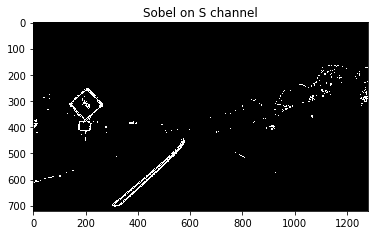

In [9]:
def apply_sobel_S(image_ud):
    image_HLS = cv2.cvtColor(gaussian_blur(image_ud, kernel=5),cv2.COLOR_RGB2HLS)

    img_gs = image_HLS[:,:,2]
    #img_gs = cv2.cvtColor(warped,cv2.COLOR_RGB2GRAY)
    sobel_c = sobel_combined(img_gs)
    #img_d_mag = dir_threshold(img_gs,3,(.6,1.1))
    #img_m_mag = mag_thresh(img_gs,5,(20,265))
    img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,255))
    img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,255))
    sobel_S_image = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    return sobel_S_image
    
plt.title('Sobel on S channel')
plt.imshow(apply_sobel_S(image_ud),cmap='gray')



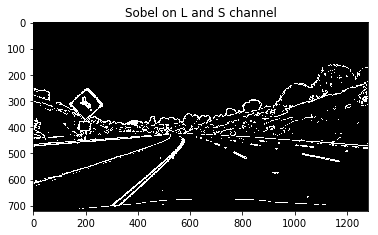

In [10]:
def apply_sobel_LS(image_ud):
    sobel_LS_image = cv2.bitwise_or(apply_sobel_L(image_ud),apply_sobel_S(image_ud))
    sobel_LS_image = gaussian_blur(sobel_LS_image,3)
    return sobel_LS_image

plt.title('Sobel on L and S channel')
plt.imshow(apply_sobel_LS(image_ud),cmap='gray')

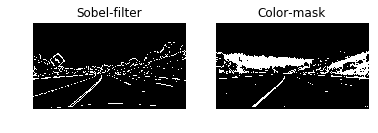

In [105]:

def apply_mask_sobel(image_ud):
    mask_YW_image = apply_yellow_white_mask(image_ud)
    sobel_LS_image = apply_sobel_LS(image_ud)
    combine_mask_sobel_image = np.zeros_like(sobel_LS_image)
    combine_mask_sobel_image[(mask_YW_image>=.5)|(sobel_LS_image>=.5)]=1
    return gaussian_blur(combine_mask_sobel_image,25)


plt.subplot(1,2,1)
plt.imshow(apply_sobel_LS(image_ud),cmap='gray')
plt.axis('off')
plt.title('Sobel-filter')
plt.subplot(1,2,2)
plt.imshow(apply_yellow_white_mask(image_ud),cmap='gray')
plt.axis('off')
plt.title('Color-mask')


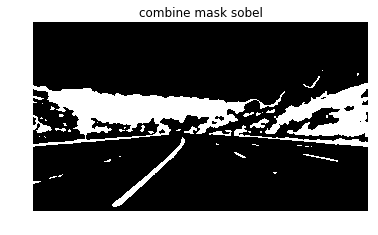

In [106]:
plt.imshow(apply_mask_sobel(image_ud),cmap='gray')
plt.axis('off')
plt.title('combine mask sobel')


## Perspective Transform

[[  585.           460.        ]
 [  203.33332825   720.        ]
 [ 1126.66662598   720.        ]
 [  695.           460.        ]]
[[ 320.    0.]
 [ 320.  720.]
 [ 960.  720.]
 [ 960.    0.]]


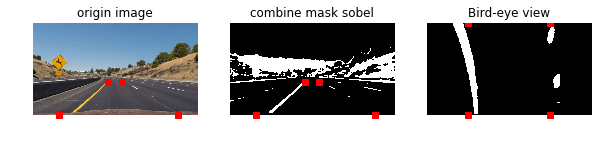

In [137]:

def apply_perspective_transform(image):
    img_size = np.shape(image)
    ht_window = np.uint(img_size[0]/1.5)
    hb_window = np.uint(img_size[0])
    c_window = np.uint(img_size[1]/2)
    ctl_window = c_window - .2*np.uint(img_size[1]/2)
    ctr_window = c_window + .2*np.uint(img_size[1]/2)
    cbl_window = c_window - .7*np.uint(img_size[1]/2)
    cbr_window = c_window + .9*np.uint(img_size[1]/2)
    

    src = np.float32([[cbl_window,hb_window],[cbr_window,hb_window],[ctr_window,ht_window],[ctl_window,ht_window]])

    
    offest = 80
    offest2 = 30
    dst = np.float32([[0 + offest,img_size[0]],[img_size[1] - offest2,img_size[0]],
                      [img_size[1] - offest2,0],[0 + offest,0]])
    
    img_size = [img_size[1], img_size[0]]
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    print(src)
    print(dst)

    #img_size = [img_size[0], img_size[1]]

    warped_image,M_warp,Minv_warp = warp_image(image,src,dst,(img_size[0],img_size[1]))
    
    return warped_image, M_warp, Minv_warp, src, dst



warped_image, M_warp, Minv_warp, src, dst = apply_perspective_transform(apply_mask_sobel(image_ud))

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(image_ud,cmap='gray')
for i in range(4):
    plt.plot(src[i][0],src[i][1],'rs')
plt.title('origin image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(apply_mask_sobel(image_ud),cmap='gray')
for i in range(4):
    plt.plot(src[i][0],src[i][1],'rs')
plt.title('combine mask sobel')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(warped_image,cmap='gray')
for i in range(4):
    plt.plot(dst[i][0],dst[i][1],'rs')
    
plt.title('Bird-eye view')
plt.axis('off');

(720, 1280)


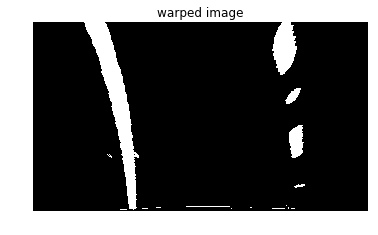

In [14]:
plt.imshow(warped_image,cmap='gray')
plt.axis('off');
plt.title('warped image')
print(warped_image.shape)

## Fit Line

(720, 1280, 3)
(720, 1280)
640
[ 0.  0.  0. ...,  0.  0.  0.]
[ 0.  0.  0. ...,  0.  0.  0.]
(1280, 720)


(0, 720)

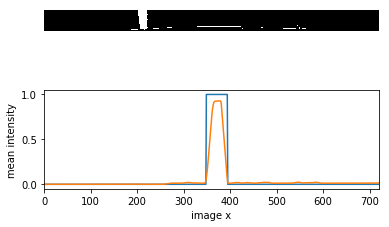

In [15]:
print(np.shape(image_ud))
print(np.shape(warped_image))
mov_filtsize = int(img_size[1]/50.)
print(int(img_size[0]/2))
mean_lane = np.mean(warped_image[int(img_size[0]/2):,:],axis=0)
print(mean_lane)
mean_lane = moving_average(mean_lane,mov_filtsize)
print(mean_lane)

print(img_size)
plt.subplot(2,1,1)
plt.imshow(warped_image[int(img_size[0]/2):,:],cmap='gray')
plt.axis('off')
plt.subplot(2,1,2)
plt.plot(mean_lane>.05)
plt.plot(mean_lane)
plt.xlabel('image x')
plt.ylabel('mean intensity')
plt.xlim(0,img_size[1])




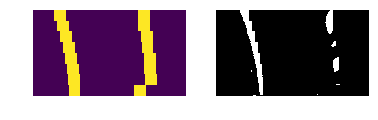

In [16]:
mask_L_poly,mask_R_poly = get_initial_mask(warped_image,50)

plt.subplot(1,2,1)
plt.imshow(mask_R_poly+mask_L_poly)
plt.axis('off')
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(cv2.bitwise_and(warped_image,warped_image,mask=mask_R_poly+mask_L_poly),cmap='gray')

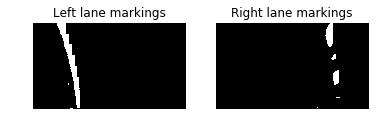

In [108]:
def get_two_lane_image(warped_image, mask_L_poly, mask_R_poly):
    img_L = np.copy(warped_image)
    img_L = cv2.bitwise_and(img_L,img_L,mask=mask_L_poly)
    img_R = np.copy(warped_image)
    img_R = cv2.bitwise_and(img_R,img_R,mask=mask_R_poly)
    
    return img_L, img_R


img_L, img_R = get_two_lane_image(warped_image, mask_L_poly, mask_R_poly)


#img_L = gaussian_blur(img_L,5)
plt.subplot(1,2,1)
plt.imshow(img_L,cmap='gray')
plt.axis('off')
plt.title('Left lane markings')
plt.subplot(1,2,2)
plt.imshow(img_R,cmap='gray')
plt.axis('off')
plt.title('Right lane markings');    

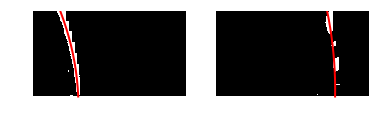

In [110]:
def get_left_fit(warped_image, mask_L_poly, mask_R_poly):
    img_L, img_R = get_two_lane_image(warped_image, mask_L_poly, mask_R_poly)
    vals = np.argwhere(img_L>.5)
    img_size = img_L.shape
    #print(vals)
    #print(vals.T)
    all_x = vals.T[0]
    all_y =vals.T[1]

    left_fit = np.polyfit(all_x, all_y, 2)
    #print(left_fit)
    left_y = np.arange(11)*img_size[0]/10
    left_fitx = left_fit[0]*left_y**2 + left_fit[1]*left_y + left_fit[2]
    
    return img_L, left_fit, left_fitx, left_y
    
def get_right_fit(warped_image, mask_L_poly, mask_R_poly):
    img_L, img_R = get_two_lane_image(warped_image, mask_L_poly, mask_R_poly)
    #print(img_R.shape)
    img_size = img_R.shape

    vals = np.argwhere(img_R>.5)
    all_x = vals.T[0]
    all_y =vals.T[1]
    right_fit = np.polyfit(all_x, all_y, 2)
    right_y = np.arange(11)*img_size[0]/10
    right_fitx = right_fit[0]*right_y**2 + right_fit[1]*right_y + right_fit[2]
    
    return img_R, right_fit, right_fitx, right_y


img_L, left_fit, left_fitx, left_y = get_left_fit(warped_image, mask_L_poly, mask_R_poly)
img_R, right_fit, right_fitx, right_y = get_right_fit(warped_image, mask_L_poly, mask_R_poly)
    

# Plot up the fake data
plt.subplot(1,2,1)
plt.imshow(img_L,cmap='gray')
plt.plot(left_fitx,left_y,'red',linewidth=2)
plt.axis('off');
    
# Plot up the fake data
plt.subplot(1,2,2)
plt.imshow(img_R,cmap='gray')
plt.plot( right_fitx,right_y,'r',linewidth=2)
plt.axis('off');

## Curvature and Center

In [19]:
## Compute center location
## Compute intercepts

def get_center(warped_image, left_fit, right_fit):
    img_size = warped_image.shape
    left_bot = get_val(img_size[0],left_fit)
    right_bot = get_val(img_size[0],right_fit)
    val_center = (left_bot+right_bot)/2.0
    #print('val_center:' + str(val_center))
    return val_center

    
def get_curve(warped_image, left_fit, right_fit):
    img_size = warped_image.shape
    left_curve = get_curvature(left_fit,img_size[0]/2)
    Right_curve = get_curvature(right_fit,img_size[0]/2)
    #print('left_curve:' + str(left_curve))
    #print('Right_curve:' + str(Right_curve))
    return left_curve, Right_curve
    
get_center(warped_image, left_fit, right_fit)
get_curve(warped_image, left_fit, right_fit)



(-2235.1777280686756, -3281.049677069369)

## Wrap Back, Draw Line

In [20]:
def wrap_back_image(image_ud, warped_image, Minv_warp, left_fitx, left_y, right_fitx, right_y):
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    img_size = warped_image.shape
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    #print(left_fitx)
    #print(left_y)
    #print()
    #print(np.vstack([left_fitx, left_y]))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
    #print()
    #print(np.transpose(np.vstack([left_fitx, left_y])))

    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y])))])

    #print()
    #print(np.transpose(np.vstack([right_fitx, right_y])))
    #print()
    #print(np.flipud(np.transpose(np.vstack([right_fitx, right_y]))))
    pts = np.hstack((pts_left, pts_right))
    #print()
    #print(pts)
    #print()
    #print(np.vstack((pts_left, pts_right)))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,180, 140))

    col_L = (255,255,0)
    col_R = (255,255,255)    


    draw_pw_lines(color_warp,np.int_(pts_left),col_L)
    draw_pw_lines(color_warp,np.int_(pts_right),col_R)


    newwarp = cv2.warpPerspective(color_warp, Minv_warp, (img_size[1], img_size[0])) 


    result = cv2.addWeighted(image_ud, 1, newwarp, 0.5, 0)
    
    return color_warp, newwarp, result

(-0.5, 1279.5, 719.5, -0.5)

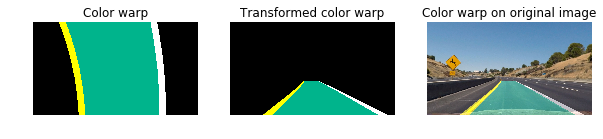

In [21]:

color_warp, newwarp, result = wrap_back_image(image_ud, warped_image, Minv_warp, left_fitx, left_y, right_fitx, right_y)
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(color_warp)
plt.axis('off')
plt.title('Color warp')
plt.subplot(1,3,2)
plt.imshow(newwarp)
plt.title('Transformed color warp')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(result)
plt.title('Color warp on original image')
plt.axis('off')

## Put all together

In [135]:

def normalized(img):
    return np.uint8(255*img/np.max(np.absolute(img)))

def to_RGB(img):
    if img.ndim == 2:
        img_normalized = normalized(img)
        return np.dstack((img_normalized, img_normalized, img_normalized))
    elif img.ndim == 3:
        return img
    else:
        return None
left_fit_prev = None
right_fit_prev = None
count = 0
col_L_prev = None
col_R_prev = None 
mask_poly_L = None
mask_poly_R = None

def process_image(img):
    
    global left_fit_prev   
    global right_fit_prev
    global count
    global col_L_prev
    global col_R_prev
    global mask_poly_L
    global mask_poly_R
    
    col_L = (255,255,0)
    col_R = (255,255,255)    

    
    pkl_file = open("camera_calibration.pkl", 'rb')
    mtx_camera, dist_camera= pickle.load(pkl_file)
    image_ud = undistort_image(img, mtx_camera , dist_camera)

    #combine_mask_sobel_image = apply_mask_sobel(image_ud)
    mask_yellow_image = apply_yellow_mask(image_ud)
    mask_white_image = apply_white_mask(image_ud)
    sobel_L_image = apply_sobel_L(image_ud)
    sobel_S_image = apply_sobel_S(image_ud)

    
    warped_image_color, M_warp, Minv_warp, src, dst = apply_perspective_transform(image_ud)

    mask_sobel_image = apply_mask_sobel(image_ud)
    warped_image, M_warp, Minv_warp, src, dst = apply_perspective_transform(mask_sobel_image)
    
    if count == 0:
        mask_poly_L,mask_poly_R = get_initial_mask(warped_image,50)

    img_L, left_fit, left_fitx, left_y = get_left_fit(warped_image, mask_poly_L, mask_poly_R)
    img_R, right_fit, right_fitx, right_y = get_right_fit(warped_image, mask_poly_L, mask_poly_R)
    
    
    #fix fit
    if count == 0:
        count = 1
        right_fit_prev = right_fit
        left_fit_prev  = left_fit
        col_L_prev = col_L
        col_R_prev = col_R
        
    ## Check error between current coefficient and on from previous frame
    err_p_R = np.sum((right_fit[0]-right_fit_prev[0])**2) #/np.sum(right_fit_prev[0]**2)
    err_p_R = np.sqrt(err_p_R)
    if err_p_R>.0005:
        right_fit = right_fit_prev
        col_R = col_R_prev
    else:
        right_fit = .05*right_fit+.95*right_fit_prev
        
    ## Compute lane mask for future frame 
    mask_poly_L,left_pts,img_pts = get_mask_poly(warped_image,left_fit,50)
    mask_poly_R,right_pts,img_pts = get_mask_poly(warped_image,right_fit,50)
     
        
    ## Check error between current coefficient and on from previous frame
    err_p_L = np.sum((left_fit[0]-left_fit_prev[0])**2) #/np.sum(right_fit_prev[0]**2)
    err_p_L = np.sqrt(err_p_L)
    if err_p_L>.0005:
        left_fit =  left_fit_prev
        col_L = col_L_prev
    else:
        left_fit =  .05* left_fit+.95* left_fit_prev
    
 
    color_warp, newwarp, result = wrap_back_image(image_ud, warped_image, Minv_warp, left_fitx, left_y, right_fitx, right_y)

    val_center = get_center(warped_image, left_fit, right_fit)
    left_curve, right_curve = get_curve(warped_image, left_fit, right_fit)
    
    dist_offset = val_center - image_ud.shape[1]/2
    dist_offset = np.round(dist_offset/2.81362,2)
    str_offset = 'Lane deviation: ' + str(dist_offset) + ' cm.'
    
    str_curv = 'Curvature: Right = ' + str(np.round(right_curve,2)) + ', Left = ' + str(np.round(left_curve,2)) 
    # Change color if distance is more than 30 cm
    font = cv2.FONT_HERSHEY_COMPLEX    

    cv2.putText(result, str_curv, (30, 60), font, 1, (0,255,0), 2)
    cv2.putText(result, str_offset, (30, 90), font, 1, (0,255,0), 2)

    
    left_fit_prev = left_fit
    right_fit_prev = right_fit
    col_R_prev = col_R
    col_L_prev = col_L
    
    return result

    """
    # debug pipeline
    # middle panel text example
    # using cv2 for drawing text in diagnostic pipeline.
    font = cv2.FONT_HERSHEY_COMPLEX
    middlepanel = np.zeros((120, 1280, 3), dtype=np.uint8)
    cv2.putText(middlepanel, str_curv, (30, 60), font, 1, (255,0,0), 2)
    cv2.putText(middlepanel, str_offset, (30, 90), font, 1, (255,0,0), 2)

    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
    img_L = to_RGB(img_L)
    draw_pw_lines(img_L,np.int_(pts_left),col_L)
    

    pts_right = np.array([np.transpose(np.vstack([right_fitx, right_y]))])
    img_R = to_RGB(img_R)
    draw_pw_lines(img_R,np.int_(pts_right),col_R)

    # assemble the screen example
    diagScreen = np.zeros((1080, 1920, 3), dtype=np.uint8)
    diagScreen[0:720, 0:1280] = result
    diagScreen[0:240, 1280:1600] = cv2.resize(mask_yellow_image, (320,240), interpolation=cv2.INTER_AREA) 
    diagScreen[0:240, 1600:1920] = cv2.resize(mask_white_image, (320,240), interpolation=cv2.INTER_AREA)
    diagScreen[240:480, 1280:1600] = cv2.resize(to_RGB(sobel_L_image), (320,240), interpolation=cv2.INTER_AREA)
    diagScreen[240:480, 1600:1920] = cv2.resize(to_RGB(sobel_S_image), (320,240), interpolation=cv2.INTER_AREA)*4
    diagScreen[600:1080, 1280:1920] = cv2.resize(to_RGB(img_L + img_R), (640,480), interpolation=cv2.INTER_AREA)*4
    diagScreen[720:840, 0:1280] = middlepanel
    diagScreen[840:1080, 0:320] = cv2.resize(image_ud, (320,240), interpolation=cv2.INTER_AREA)
    diagScreen[840:1080, 320:640] = cv2.resize(warped_image_color, (320,240), interpolation=cv2.INTER_AREA)
    diagScreen[840:1080, 640:960] = cv2.resize(color_warp, (320,240), interpolation=cv2.INTER_AREA)
    diagScreen[840:1080, 960:1280] = cv2.resize(newwarp, (320,240), interpolation=cv2.INTER_AREA)



    return diagScreen
    """
    

(-0.5, 1279.5, 719.5, -0.5)

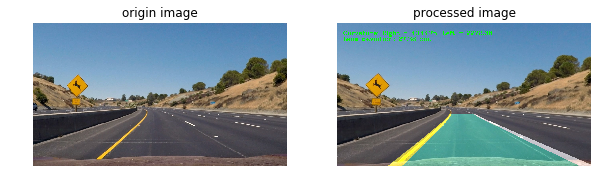

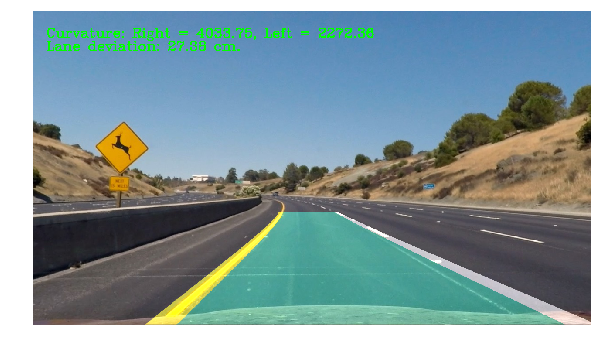

In [136]:
fname = 'test_images/test'+ str(2) + '.jpg'
img = mpimg.imread(fname)

result = process_image(img)


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('origin image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(result)
plt.title('processed image')
plt.axis('off')


plt.figure(figsize=(10,10))
plt.imshow(result)
plt.axis('off')


## Process Video

In [134]:

import imageio
#print('xxx')
#imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'project_video_output.mp4'
clip2 = VideoFileClip('project_video.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



100%|█████████▉| 1260/1261 [18:24<00:00,  1.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 21min 49s, sys: 6.64 s, total: 21min 56s
Wall time: 18min 25s
